In [131]:
import torch 

import matplotlib.pyplot as plt

import os
import pandas as pd

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F


from torchvision.models import resnet50, ResNet50_Weights

In [132]:
rgb_cnn = resnet50(weights=ResNet50_Weights.DEFAULT)
depth_cnn = resnet50(weights=ResNet50_Weights.DEFAULT)


depth_cnn.fc = nn.Sequential(
    nn.Dropout(p=0.4),
    nn.Linear(2048,100,bias=True),
    nn.Tanh()
)

rgb_cnn.fc = nn.Sequential(
    nn.Dropout(p=0.4),
    nn.Linear(2048,100,bias=True),
    nn.Tanh()
)

final_pose_estimator = nn.Sequential(
    nn.Dropout(p=0.4),
    nn.Linear(200, 6, bias=True)

)



def paralle_cnn(rgb, depth):
    rgb_out = rgb_cnn(rgb)
    depth_out = rgb_cnn(depth)
    cat_out = torch.cat([rgb_out, depth_out], dim=1)
    return final_pose_estimator(cat_out)

#torch.load('dual_resnet50pose_depth.pth',map_location=torch.device('cpu'))


depth_cnn.load_state_dict(torch.load('dual_resnet50pose_depth.pth',map_location=torch.device('cpu')))
rgb_cnn.load_state_dict(torch.load('dual_resnet50pose_rgb.pth',map_location=torch.device('cpu')))
final_pose_estimator.load_state_dict(torch.load('dual_final_pose_estimator.pth',map_location=torch.device('cpu')))


<All keys matched successfully>

In [133]:
# we will save the conv layer weights in this list
model_weights =[]
#we will save the 49 conv layers in this list
conv_layers = []
# get all the model children as list
model_children = list(rgb_cnn.children())
#counter to keep count of the conv layers
counter = 0
#append all the conv layers and their respective wights to the list
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter+=1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Conv2d:
                    counter+=1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
print(f"Total convolution layers: {counter}")
print("conv_layers")





Total convolution layers: 49
conv_layers


49
torch.Size([64, 112, 112])
torch.Size([64, 112, 112])
torch.Size([64, 112, 112])
torch.Size([256, 112, 112])
torch.Size([64, 112, 112])
torch.Size([64, 112, 112])
torch.Size([256, 112, 112])
torch.Size([64, 112, 112])
torch.Size([64, 112, 112])
torch.Size([256, 112, 112])
torch.Size([128, 112, 112])
torch.Size([128, 56, 56])
torch.Size([512, 56, 56])
torch.Size([128, 56, 56])
torch.Size([128, 56, 56])
torch.Size([512, 56, 56])
torch.Size([128, 56, 56])
torch.Size([128, 56, 56])
torch.Size([512, 56, 56])
torch.Size([128, 56, 56])
torch.Size([128, 56, 56])
torch.Size([512, 56, 56])
torch.Size([256, 56, 56])
torch.Size([256, 28, 28])
torch.Size([1024, 28, 28])
torch.Size([256, 28, 28])
torch.Size([256, 28, 28])
torch.Size([1024, 28, 28])
torch.Size([256, 28, 28])
torch.Size([256, 28, 28])
torch.Size([1024, 28, 28])
torch.Size([256, 28, 28])
torch.Size([256, 28, 28])
torch.Size([1024, 28, 28])
torch.Size([256, 28, 28])
torch.Size([256, 28, 28])
torch.Size([1024, 28, 28])
torch.Size([256

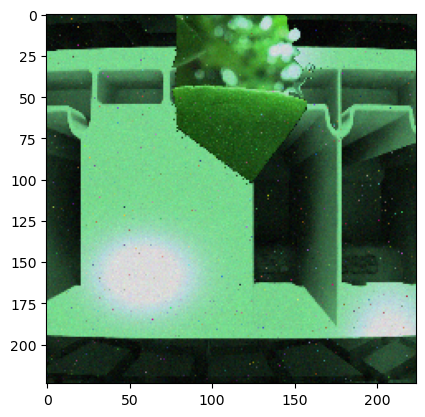

In [134]:
from PIL import Image

from torchvision.transforms import transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=0., std=1.)
])

image = Image.open("/home/a/seasony/dataset_nd_rgb_resize-10k/dataset/rgb/rgb_image_5.png")

plt.imshow(image)

image = transform(image)

outputs = []
names = []
for layer in conv_layers[0:]:
    image = layer(image)
    outputs.append(image)
    names.append(str(layer))
print(len(outputs))
#print feature_maps
for feature_map in outputs:
    print(feature_map.shape)


49


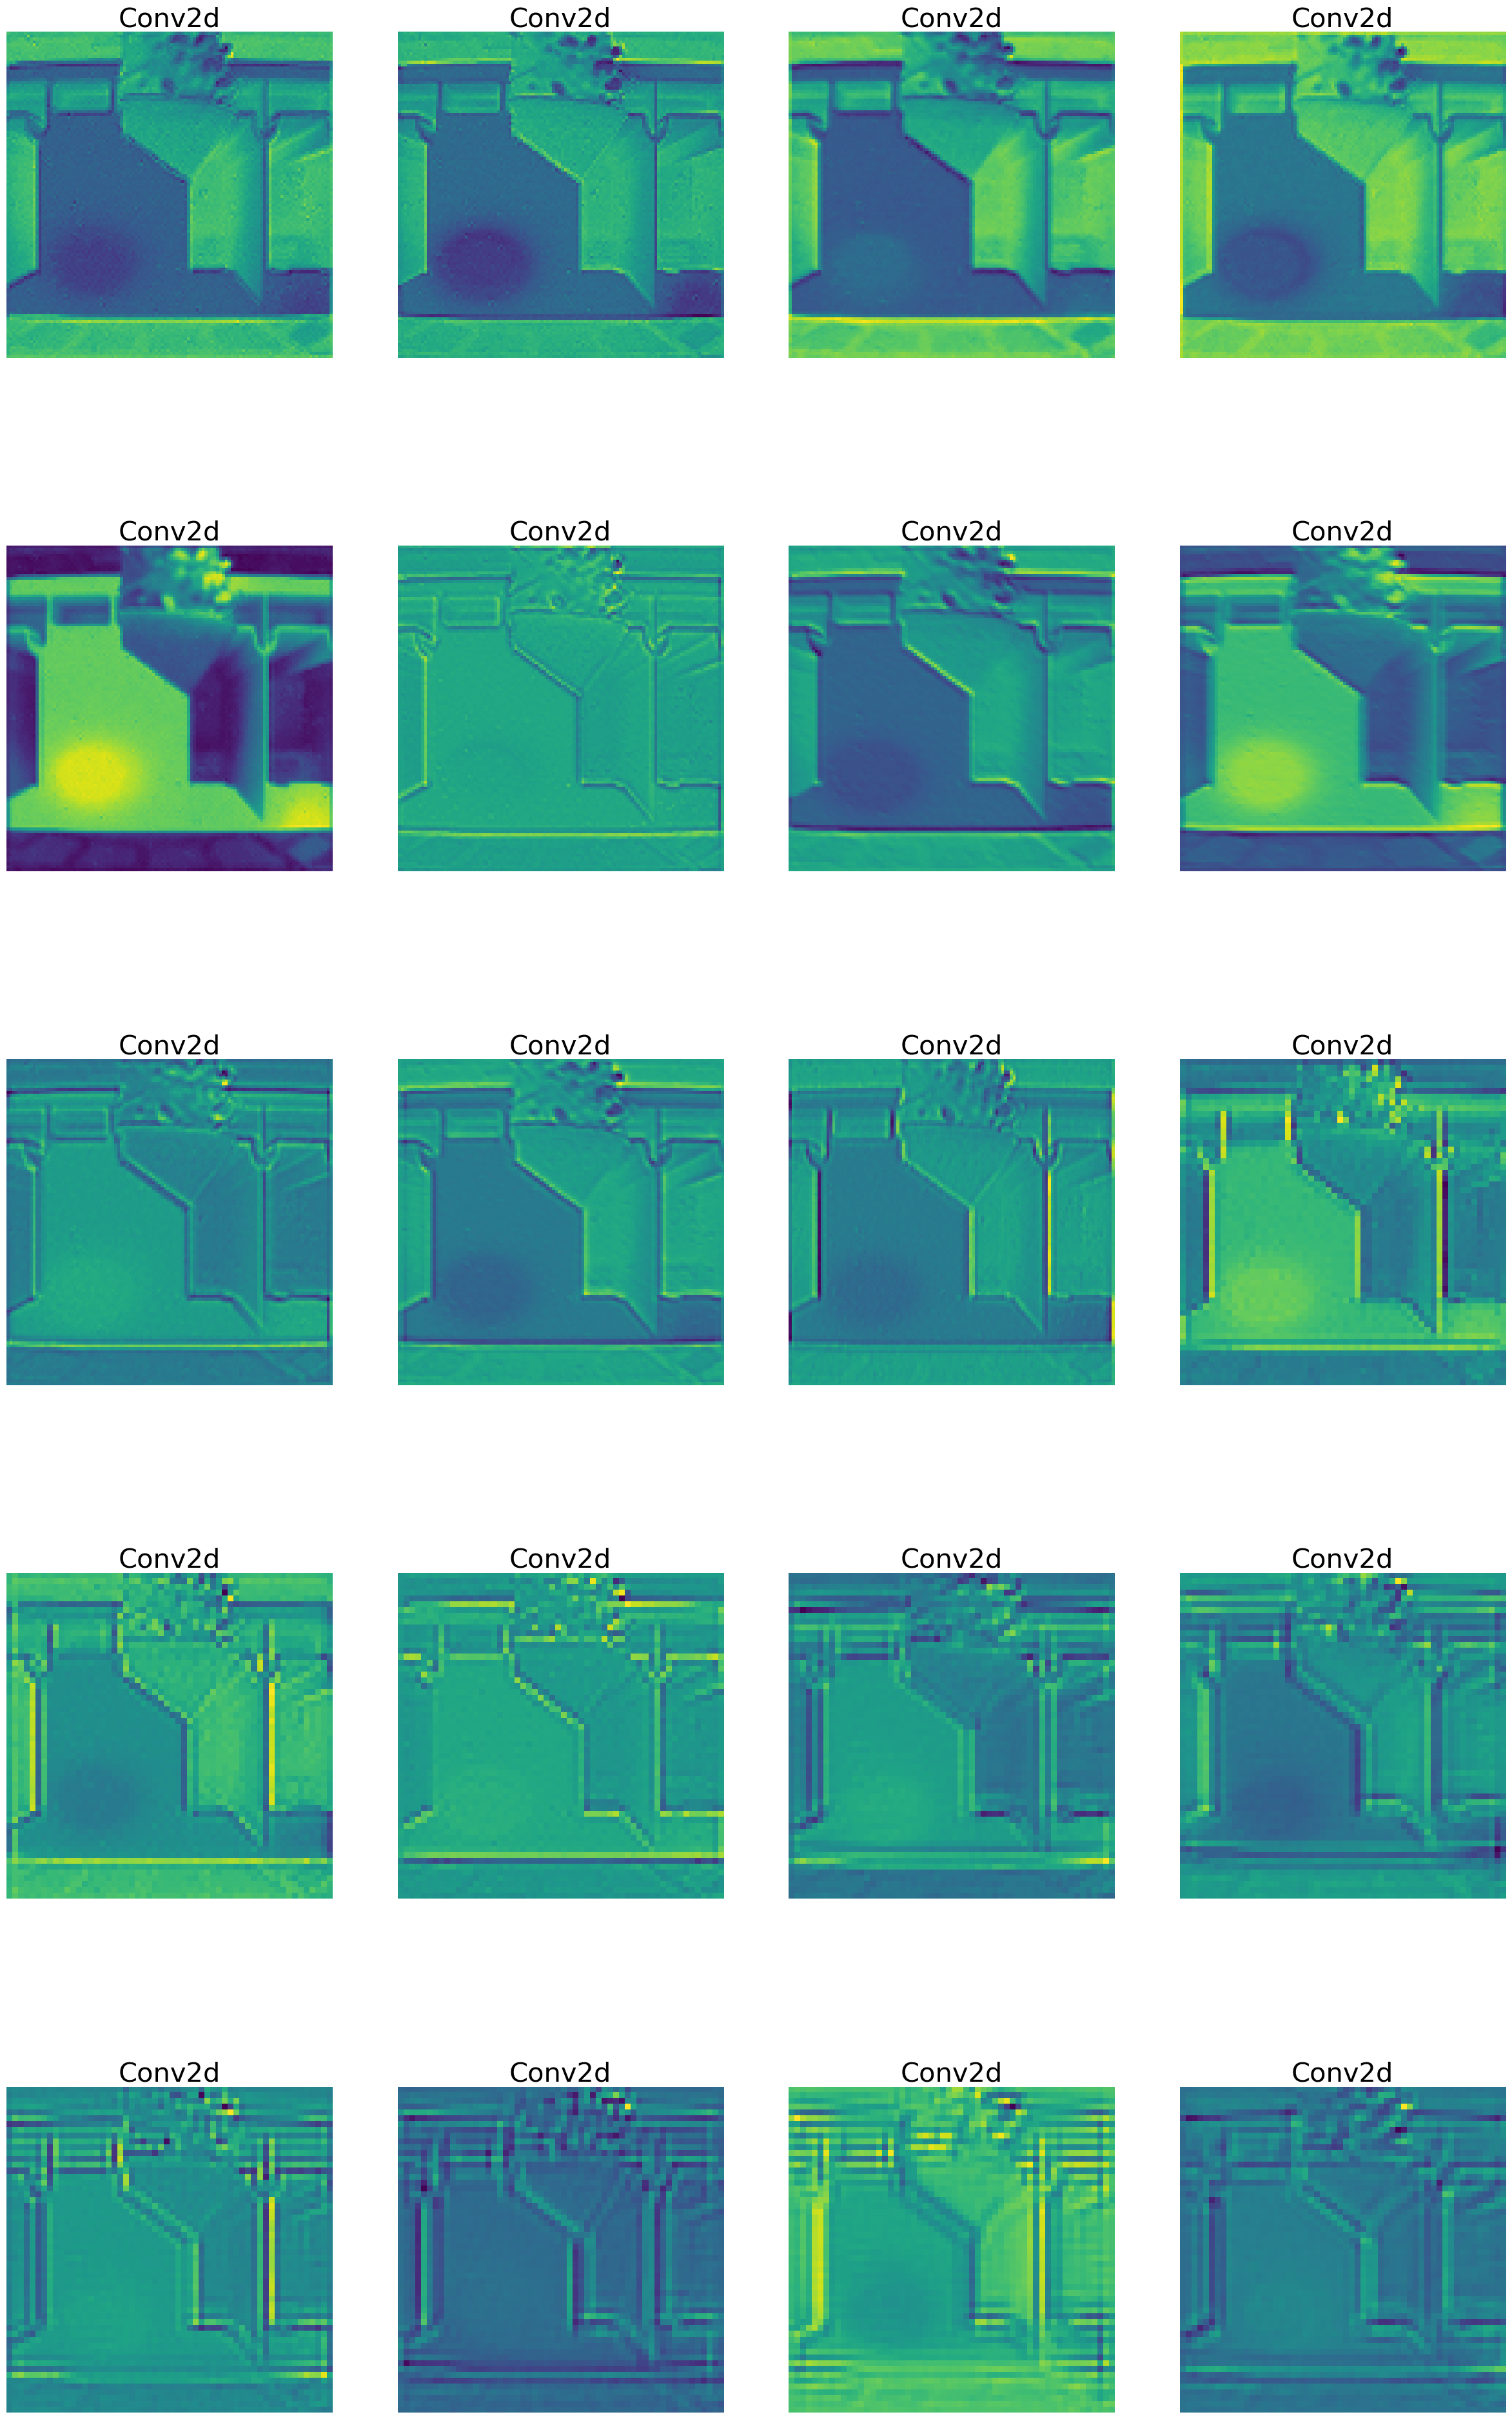

In [135]:
processed = []
for feature_map in outputs:
    feature_map = feature_map.squeeze(0)
    gray_scale = torch.sum(feature_map,0)
    gray_scale = gray_scale / feature_map.shape[0]
    processed.append(gray_scale.data.cpu().numpy())
#for fm in processed:
#    print(fm.shape)


print(len(processed))

fig = plt.figure(figsize=(30, 50))
for i in range(len(processed))[0:20]:
    a = fig.add_subplot(5, 4, i+1)
    imgplot = plt.imshow(processed[i])
    a.axis("off")
    a.set_title(names[i].split('(')[0], fontsize=30)
plt.savefig(str('feature_maps.jpg'), bbox_inches='tight')

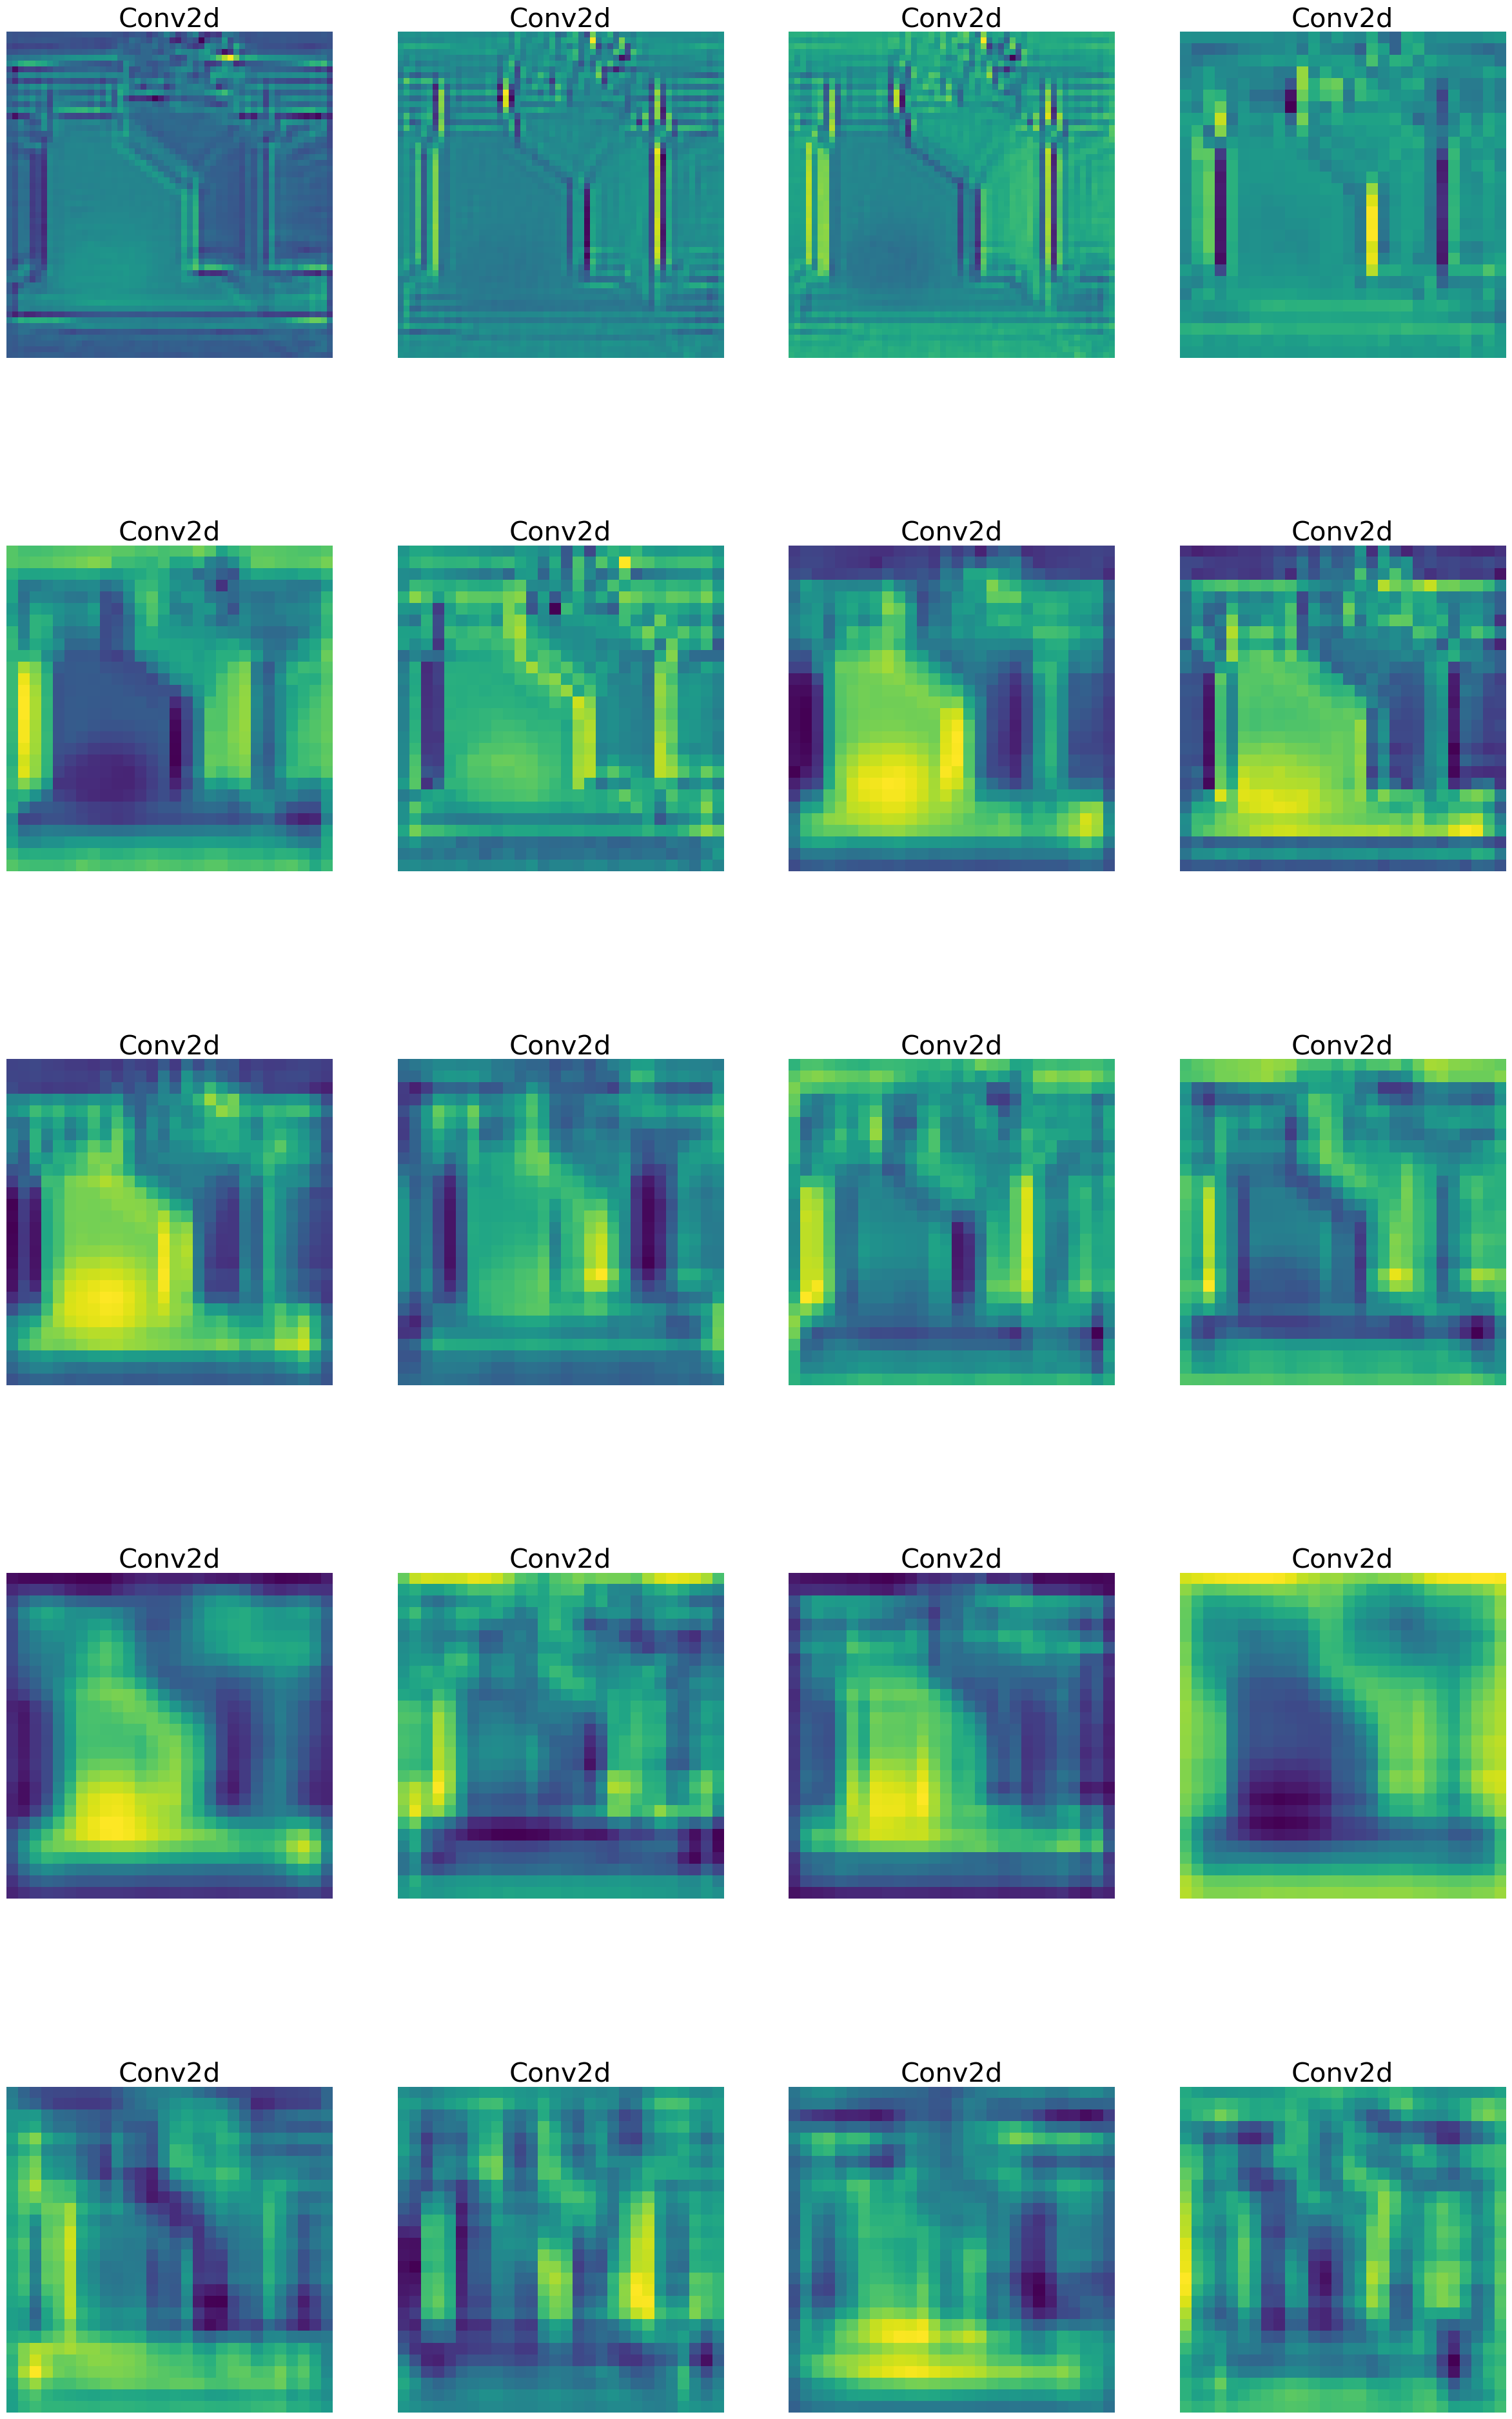

In [136]:
fig = plt.figure(figsize=(30, 50))
for i in range(len(processed))[20:40]:
    a = fig.add_subplot(5, 4, i-19)
    imgplot = plt.imshow(processed[i])
    a.axis("off")
    a.set_title(names[i].split('(')[0], fontsize=30)
plt.savefig(str('feature_maps.jpg'), bbox_inches='tight')

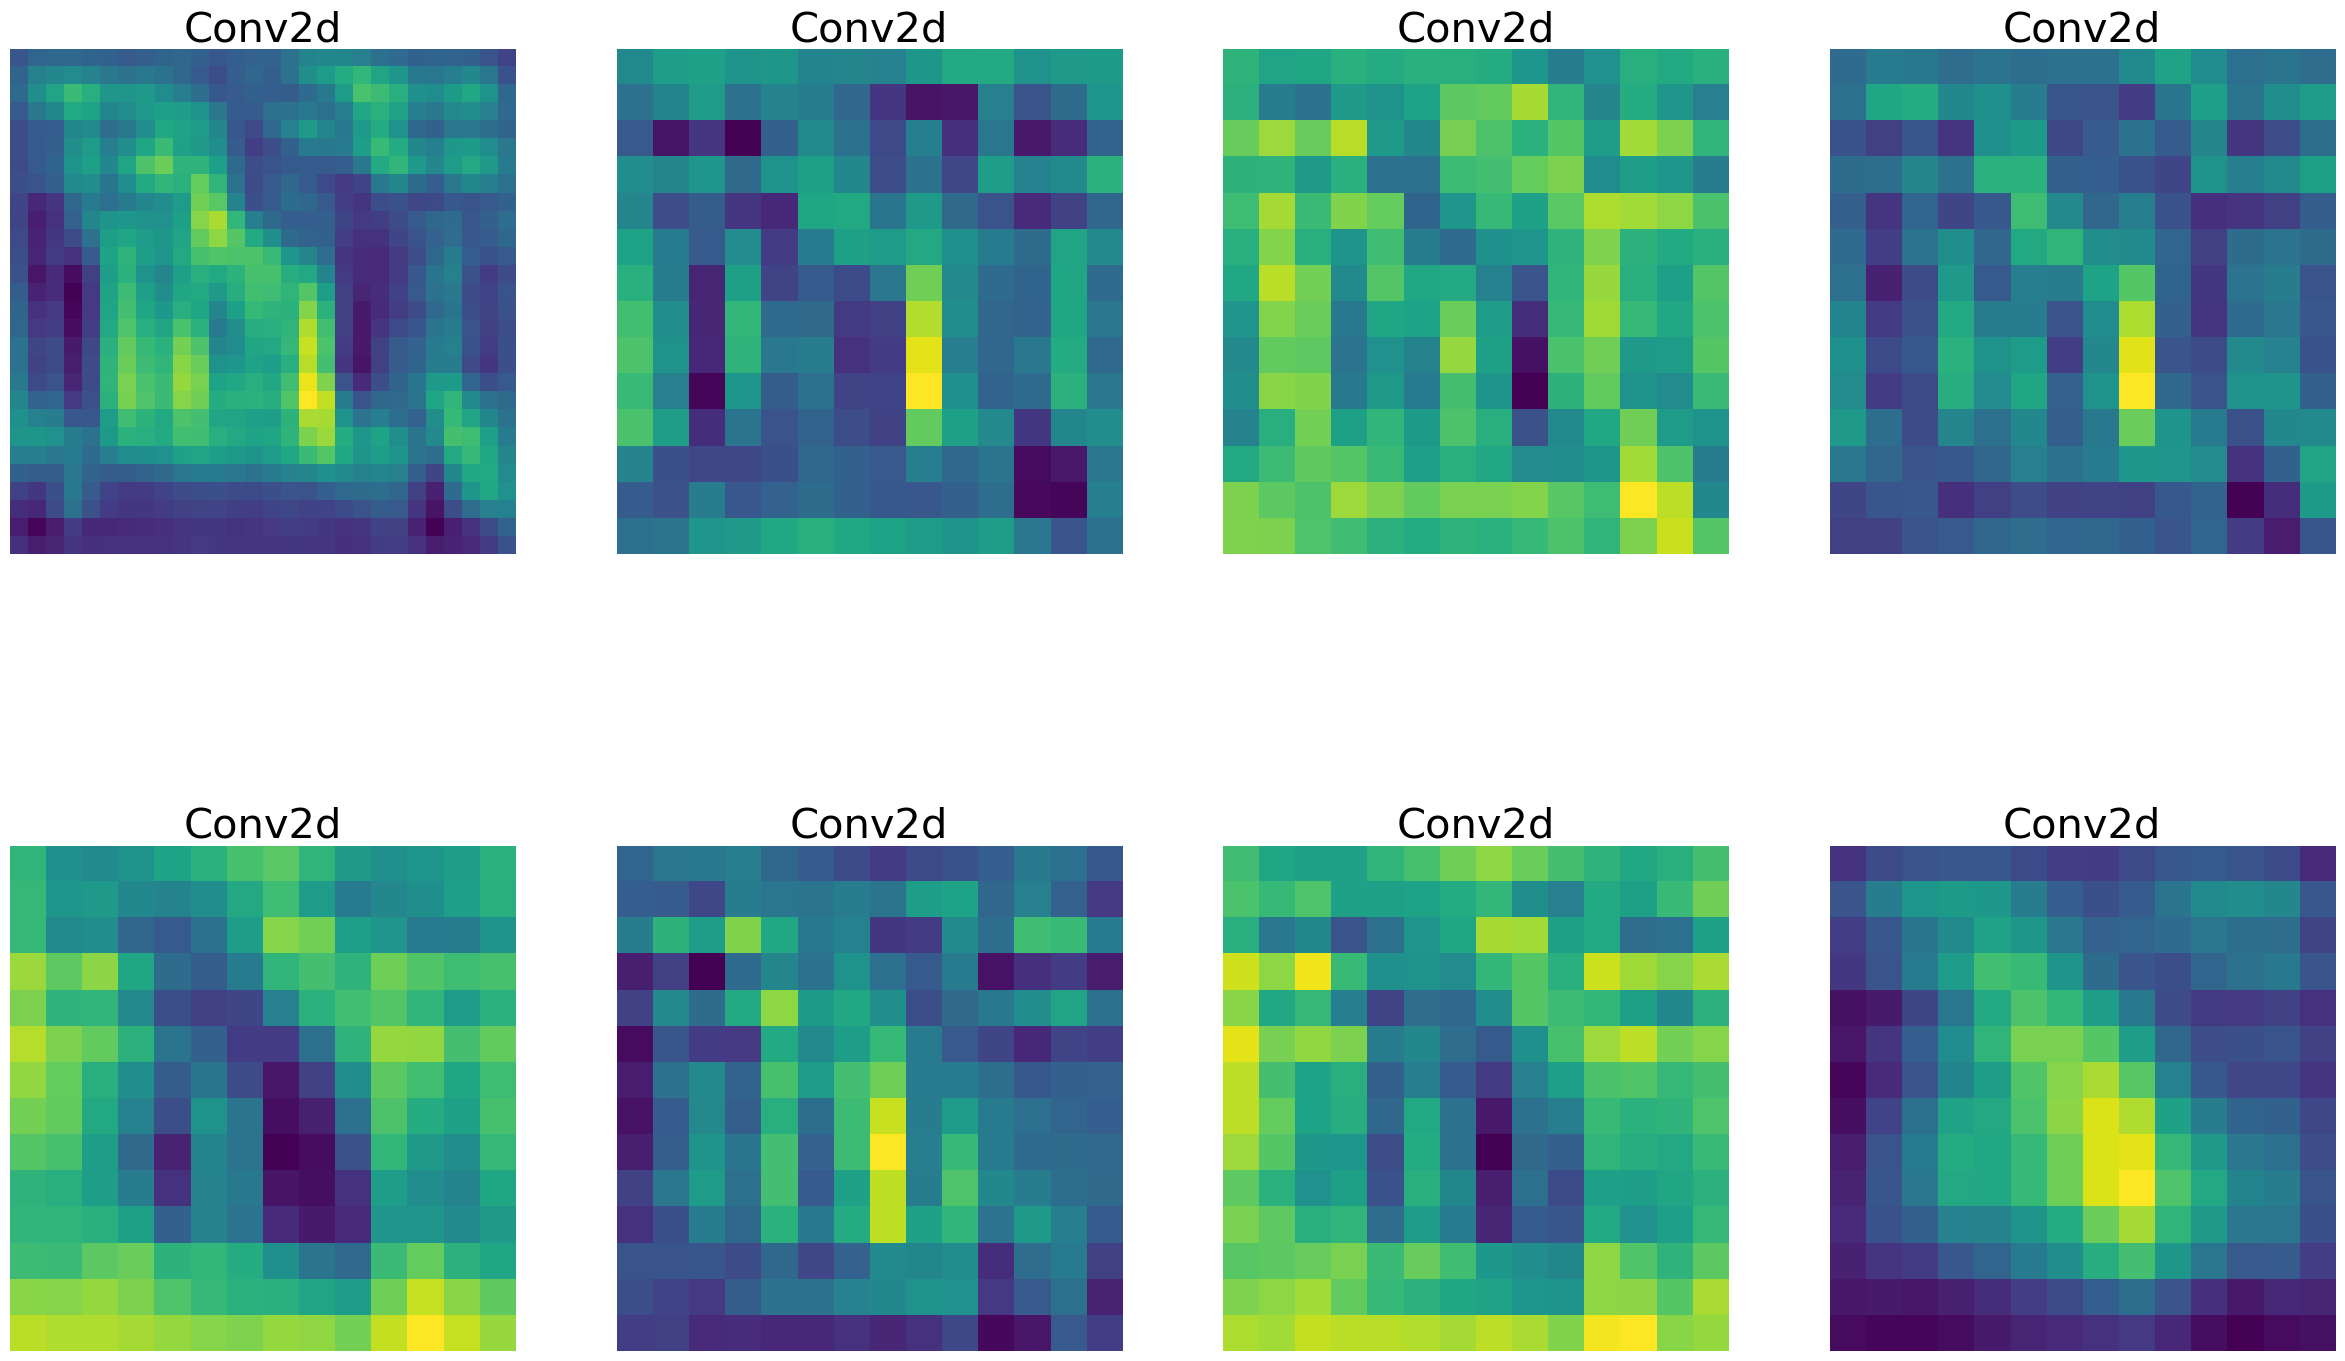

In [137]:
fig = plt.figure(figsize=(30, 50))
for i in range(len(processed))[40:-1]:
    a = fig.add_subplot(5, 4, i-39)
    imgplot = plt.imshow(processed[i])
    a.axis("off")
    a.set_title(names[i].split('(')[0], fontsize=30)
plt.savefig(str('feature_maps.jpg'), bbox_inches='tight')

In [138]:
for key in depth_cnn.state_dict():
    print([key])


['conv1.weight']
['bn1.weight']
['bn1.bias']
['bn1.running_mean']
['bn1.running_var']
['bn1.num_batches_tracked']
['layer1.0.conv1.weight']
['layer1.0.bn1.weight']
['layer1.0.bn1.bias']
['layer1.0.bn1.running_mean']
['layer1.0.bn1.running_var']
['layer1.0.bn1.num_batches_tracked']
['layer1.0.conv2.weight']
['layer1.0.bn2.weight']
['layer1.0.bn2.bias']
['layer1.0.bn2.running_mean']
['layer1.0.bn2.running_var']
['layer1.0.bn2.num_batches_tracked']
['layer1.0.conv3.weight']
['layer1.0.bn3.weight']
['layer1.0.bn3.bias']
['layer1.0.bn3.running_mean']
['layer1.0.bn3.running_var']
['layer1.0.bn3.num_batches_tracked']
['layer1.0.downsample.0.weight']
['layer1.0.downsample.1.weight']
['layer1.0.downsample.1.bias']
['layer1.0.downsample.1.running_mean']
['layer1.0.downsample.1.running_var']
['layer1.0.downsample.1.num_batches_tracked']
['layer1.1.conv1.weight']
['layer1.1.bn1.weight']
['layer1.1.bn1.bias']
['layer1.1.bn1.running_mean']
['layer1.1.bn1.running_var']
['layer1.1.bn1.num_batches_trac

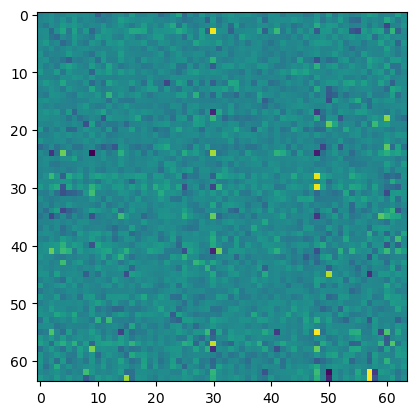

In [139]:
depth_conv3_w = np.array(depth_cnn.state_dict()['layer1.0.conv2.weight'])

plt.imshow(depth_conv3_w[:,:,0,0])

[0.07461039, -0.07424401]


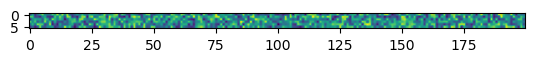

In [140]:
depth_fc_weight = np.array(depth_cnn.state_dict()['fc.1.weight'])
depth_fc_bias = np.array(depth_cnn.state_dict()['fc.1.bias'])

rgb_fc_weight = np.array(rgb_cnn.state_dict()['fc.1.weight'])


#print(depth_fc_bias)

#plt.imshow(np.concatenate((np.sort(depth_fc_weight), np.sort(rgb_fc_weight))))



fpc_weight = np.array(final_pose_estimator.state_dict()['1.weight'])

fpc_bias = np.array(final_pose_estimator.state_dict()['1.bias'])

print([np.max(fpc_weight), np.min(fpc_weight)])

plt.imshow(fpc_weight)

plt.show()



